## Solving for eigenvalues and eigenvectors

We saw in the previous notebook how to set up a matrix by integrating between pairs of basis functions.  In this notebook we will solve for the eigenvalues and eigenvectors of the Hamiltonian for a square well, exploring what happens when we use a finite basis set, and introduce changes to the potential in the square well.

### Eigenbasis, adding potential

We will start by using the eigenbasis (since it's simple) and will add small changes to the potential.  This will give us some insight into the effect of perturbations (and will feed directly into our studies of perturbation theory).  So we'll first set up the bits and pieces of code we'll need, some taken from the previous notebook.

In [2]:
# Import libraries and set up in-line plotting.
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
# This is a new library - linear algebra includes solving for eigenvalues & eigenvectors of matrices
import numpy.linalg as la

# Define the eigenbasis - normalisation needed elsewhere
# There is a way to make this return a stub that we pass n and norm to
def eigenbasis_sw(n,width,norm,x):
    """The eigenbasis for a square well, running from 0 to a, sin(n pi x/a)"""
    fac = np.pi*n/width
    return norm*np.sin(fac*x)

# We will also define the second derivative for kinetic energy (KE)
def d2eigenbasis_sw(n,width,norm,x):
    """The eigenbasis for a square well, running from 0 to a, sin(n pi x/a)"""
    fac = np.pi*n/width
    return -fac*fac*norm*np.sin(fac*x)

# Define the x-axis
width = 1.0
num_x_points = 101
x = np.linspace(0.0,width,num_x_points)
dx = width/(num_x_points - 1)

# Integrate two functions over the width of the well
def integrate_functions(f1,f2,size_x,dx):
    """Integrate two functions over defined x range"""
    sum = 0.0
    for i in range(size_x):
        sum = sum + f1[i]*f2[i]
    sum = sum*dx
    return sum

# Now set up the array of basis functions - specify the size of the basis
num_basis = 10
# These arrays will each hold an array of functions
basis_array = np.zeros((num_basis,num_x_points))
d2basis_array = np.zeros((num_basis,num_x_points))

# Loop over first num_basis basis states, normalise and create an array
# NB the basis_array will start from 0
for i in range(num_basis):
    n = i+1
    # Calculate A = <phi_n|phi_n>
    integral = integrate_functions(eigenbasis_sw(n,width,1.0,x),eigenbasis_sw(n,width,1.0,x),num_x_points,dx)
    # Use 1/sqrt{A} as normalisation constant
    normalisation = 1.0/np.sqrt(integral)
    basis_array[i,:] = eigenbasis_sw(n,width,normalisation,x)
    d2basis_array[i,:] = d2eigenbasis_sw(n,width,normalisation,x)

We have now set up all the mechanics that we need to create matrices for different Hamiltonians, except for one thing: the potential.  We have an implicit potential already in the infinite square well (we set $V=\infty$ when $x=0$ or $x=a$).  If we create a potential function, then we can change this and create different Hamiltonian matrices.  So we'll do this next.

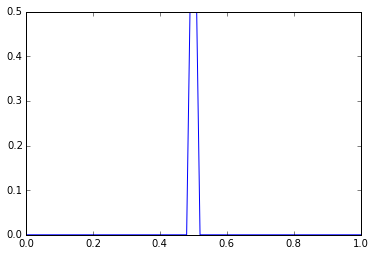

In [3]:
# Define the potential in the square well
def square_well_potential(x,V,a):
    """Potential for a particle in a square well, expecting two arrays: x, V(x), and potential height, a"""
    for i in range(x.size):
        V[i] = 0.0
    # Let's define a small bump in the middle of the well
    i_mid = x.size/2
    V[i_mid-1] = a
    V[i_mid] = a
    V[i_mid+1] = a
    # Plot to ensure that we know what we're getting
    pl.plot(x,V)
    
# Declare space for this potential (Vbump) and call the routine
Vbump = np.linspace(0.0,width,num_x_points)
pot_bump = square_well_potential(x,Vbump,0.5)

### Solving for the eigenvalues

Now that we have the potential, we need to build the matrix (remember that we have set $\hbar = m = 1$):

$H_{mn} = \langle \phi_m \vert -\frac{1}{2}\nabla^2 + \hat{V}\vert\phi_n\rangle$

By diagonalisation, we will find the eigenvalues.

It's worth noting that we act with $\hat{V}$ by multiplication in position representation:

$$\langle x \vert \hat{V} \vert \phi_m\rangle = V(x) \phi_m(x)$$

We will print out the matrix of _just_ the potential first: this will be useful when thinking about perturbation theory (the change in eigenvalues should be the same as the diagonal elements of the potential matrix, to first order in the potential).

In [14]:
# Declare space for the matrix elements - simplest with the identity function
Hmat = np.eye(num_basis)

# Define a function to act on a basis function with the potential
def add_pot_on_basis(Hphi,V,phi):
    for i in range(V.size):
        Hphi[i] = Hphi[i] + V[i]*phi[i]
        
print "Potential matrix elements:"
# Loop over basis functions phi_n (the bra in the matrix element)
# Calculate and output matrix elements of the potential

for n in range(num_basis):
    # Loop over basis functions phi_m (the ket in the matrix element)
    for m in range(num_basis):
        # Act with H on phi_m and store in H_phi_m
        H_phi_m = np.zeros(num_x_points)
        add_pot_on_basis(H_phi_m,Vbump,basis_array[m])
        # Create matrix element by integrating
        H_mn = integrate_functions(basis_array[n],H_phi_m,num_x_points,dx)
        # The comma at the end prints without a new line; the %8.3f formats the number
        print "%8.3f" % H_mn,
    # This print puts in a new line when we have finished looping over m
    print

print
print "Full Hamiltonian"
# Loop over basis functions phi_n (the bra in the matrix element)
# Calculate and store the matrix elements for the full Hamiltonian
for n in range(num_basis):
    # Loop over basis functions phi_m (the ket in the matrix element)
    for m in range(num_basis):
        # Act with H on phi_m and store in H_phi_m
        # First the kinetic energy
        H_phi_m = -0.5*d2basis_array[m] 
        # Now the potential
        add_pot_on_basis(H_phi_m,Vbump,basis_array[m])
        # Create matrix element by integrating
        H_mn = integrate_functions(basis_array[n],H_phi_m,num_x_points,dx)
        Hmat[m,n] = H_mn
        # The comma at the end prints without a new line; the %8.3f formats the number
        print "%8.3f" % H_mn,
    # This print puts in a new line when we have finished looping over m
    print

Potential matrix elements:
   0.030    0.000   -0.030   -0.000    0.030    0.000   -0.030   -0.000    0.029    0.000
   0.000    0.000   -0.000   -0.000    0.000    0.000   -0.000   -0.000    0.000    0.000
  -0.030   -0.000    0.030    0.000   -0.030   -0.000    0.029    0.000   -0.029   -0.000
  -0.000   -0.000    0.000    0.000   -0.000   -0.000    0.000    0.001   -0.000   -0.001
   0.030    0.000   -0.030   -0.000    0.030    0.000   -0.029   -0.000    0.029    0.000
   0.000    0.000   -0.000   -0.000    0.000    0.001   -0.000   -0.001    0.000    0.001
  -0.030   -0.000    0.029    0.000   -0.029   -0.000    0.029    0.000   -0.029   -0.000
  -0.000   -0.000    0.000    0.001   -0.000   -0.001    0.000    0.001   -0.000   -0.002
   0.029    0.000   -0.029   -0.000    0.029    0.000   -0.029   -0.000    0.028    0.000
   0.000    0.000   -0.000   -0.001    0.000    0.001   -0.000   -0.002    0.000    0.002

Full Hamiltonian
   4.965   -0.000   -0.030   -0.000    0.030    0.000  

Notice that two things have changed compared to the perfect square well: first, the diagonal elements are _slightly_ larger; second, there are now off-diagonal elements.  Does it surprise that these alternate (i.e. only in odd row and columns) ? Think about the symmetries of the system, particularly of the wavefunctions.

What effect will this have on the eigenvalues and eigenvectors ? We'll diagonalise, print out the eigenvalues and plot the first few eigenvectors (as well as looking at their coefficients to get a rough idea of how much they've changed).

In [5]:
# Solve using linalg module of numpy (which we've imported as la above)
eigval, eigvec = la.eigh(Hmat)
# This call above does the entire solution for the eigenvalues and eigenvectors !
# Print results roughly, though apply precision of 4 to the printing
np.set_printoptions(precision=4)
print eigval
print eigvec[0]
print eigvec[1]
print eigvec[2]

[   4.9647   19.7393   44.443    78.9571  123.3996  177.6536  241.8344
  315.8286  399.7474  493.4821]
[  1.0000e+00  -2.0635e-17   7.5696e-04  -7.1521e-17  -2.5115e-04
   7.7171e-17  -1.2461e-04   3.6019e-17  -7.3983e-05   5.9905e-17]
[  2.2443e-17   1.0000e+00  -2.2204e-15  -2.6578e-06   2.2204e-16
   1.4901e-06   5.5511e-17   1.0548e-06   3.8858e-16  -8.1916e-07]
[  7.5708e-04  -2.2204e-15  -1.0000e+00  -3.4056e-16   3.7569e-04
   1.3964e-16   1.4913e-04   1.0053e-16   8.1990e-05  -2.4266e-16]


We can see that the eigenvalues look close to the perfect well values (we'll check them properly below).  The eigenvector coefficients show a single dominant value (corresponding to the unchanged eigenvector), with very small contributions from other eigenvectors.  Now print the eigenvalues and calculate the change.

In [6]:
# Now print out eigenvalues and the eigenvalues of the perfect square well, and the difference
print " Changed Original  Difference"
for i in range(num_basis):
    n = i+1
    print "%8.3f %8.3f %8.3f" % (eigval[i],n*n*np.pi*np.pi/2.0,eigval[i] - n*n*np.pi*np.pi/2.0)

 Changed Original  Difference
   4.965    4.935    0.030
  19.739   19.739    0.000
  44.443   44.413    0.030
  78.957   78.957    0.000
 123.400  123.370    0.030
 177.654  177.653    0.001
 241.834  241.805    0.029
 315.829  315.827    0.001
 399.747  399.719    0.028
 493.482  493.480    0.002


Compare the differences in eigenvalues due to the small potential we've added to the diagonal terms of the potential matrix.  How close is the agreement ? You might like to change the magnitude of the potential (higher up - it's passed as an argument to the potential function) and see how this agreement changes.

Now we'll plot the eigenvectors (after building them) and look at the change with respect to the eigenvectors of the original system.  Remember that any function in this space can be written as:

$$\vert\psi\rangle = \sum_i c_i \vert \phi_i \rangle$$

We'll use this to build the eigenfunctions of the perturbed system.  In this case, $c_i$ are the coefficients in the eigenvector of the matrix, and $\vert\phi_i\rangle$ are the basis functions.

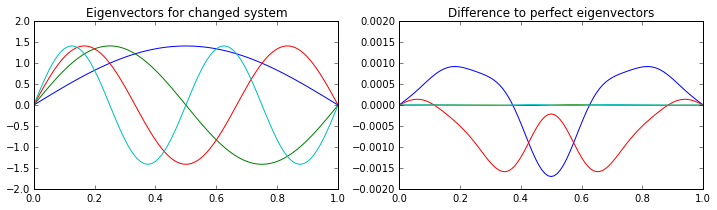

In [7]:
# Define a figure to take two plots
fig = pl.figure(figsize=[12,3])
# Add subplots: number in y, x, index number
ax = fig.add_subplot(121,autoscale_on=False,xlim=(0,1),ylim=(-2,2))
ax.set_title("Eigenvectors for changed system")
ax2 = fig.add_subplot(122,autoscale_on=False,xlim=(0,1),ylim=(-0.002,0.002))
ax2.set_title("Difference to perfect eigenvectors")
for m in range(4): # Plot the first four states
    psi = np.zeros(num_x_points)
    for i in range(num_basis):
        psi = psi+eigvec[i,m]*basis_array[i]
    if eigvec[m,m] < 0:  # This is just to ensure that psi and the basis function have the same phase
        psi = -psi
    ax.plot(x,psi)
    psi = psi - basis_array[m]
    ax2.plot(x,psi)


Notice how the eigenvectors for this changed system are *very* close to the original system.  This is a perfect example of a good system to study with perturbation theory.  The changes in the eigenvectors can be related to matrix elements of the potential, but we won't do this just yet.

## A more drastic change in the potential

Now let's try a more significant change to the potential.  It will be instructive to place a quantum harmonic oscillator potential into our square well, and then build the Hamiltonian, again using the square well eigenvectors as a basis set.  We will look at two cases: first, a small magnitude for the potential (a small perturbation, where we would expect to see small changes in the square well energies); second, a large magnitude for the potential (where the first few eigenstates should be very close to the QHO eigenstates).

### Small perturbation - close to square well

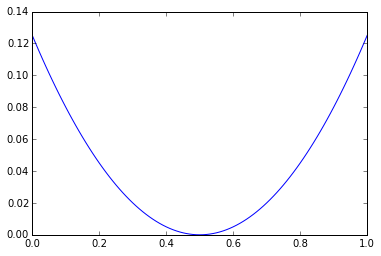

In [16]:
# Define the potential in the square well
def square_well_potential2(x,V,a):
    """QHO Potential for a particle in a square well, expecting two arrays: x, V(x), and potential height, a"""
    # Note that we offset x so that the QHO well is centred on the square well
    for i in range(x.size):
        V[i] = 0.5*a*(x[i]-0.5)**2 
    # Plot to ensure that we know what we're getting
    pl.plot(x,V)
    
omega = 1.0
omega2 = omega*omega
VbumpQHO = np.linspace(0.0,width,num_x_points)
pot_bump = square_well_potential2(x,VbumpQHO,omega2)

In [18]:
# Declare space for the matrix elements
Hmat2 = np.eye(num_basis)

# Loop over basis functions phi_n (the bra in the matrix element)
for n in range(num_basis):
    # Loop over basis functions phi_m (the ket in the matrix element)
    for m in range(num_basis):
        # Act with H on phi_m and store in H_phi_m
        H_phi_m = -0.5*d2basis_array[m] 
        add_pot_on_basis(H_phi_m,VbumpQHO,basis_array[m])
        # Create matrix element by integrating
        Hmat2[m,n] = integrate_functions(basis_array[n],H_phi_m,num_x_points,dx)
        # The comma at the end prints without a new line; the %8.3f formats the number
        print "%8.3f" % Hmat2[m,n],
    # This print puts in a new line when we have finished looping over m
    print
    
print "Perturbation matrix elements:"
# Output the matrix elements of the potential to see how large the perturbation is
# Loop over basis functions phi_n (the bra in the matrix element)
for n in range(num_basis):
    # Loop over basis functions phi_m (the ket in the matrix element)
    for m in range(num_basis):
        # Act with H on phi_m and store in H_phi_m
        H_phi_m = np.zeros(num_x_points)
        add_pot_on_basis(H_phi_m,VbumpQHO,basis_array[m])
        # Create matrix element by integrating
        H_mn = integrate_functions(basis_array[n],H_phi_m,num_x_points,dx)
        # The comma at the end prints without a new line; the %8.3f formats the number
        print "%8.3f" % H_mn,
    # This print puts in a new line when we have finished looping over m
    print
    
# Solve using linalg module of numpy (which we've imported as la above)
eigval, eigvec = la.eigh(Hmat2)
# This call above does the entire solution for the eigenvalues and eigenvectors !
# Print results roughly, though apply precision of 4 to the printing
print
print "Eigenvalues and eigenvector coefficients printed roughly"
np.set_printoptions(precision=4)
print eigval
print eigvec[0]
print eigvec[1]
print eigvec[2]
print

print " QHO Square  Perfect QHO  Difference  Perfect Square Difference"
for i in range(num_basis):
    n = i+1
    print "   %8.3f     %8.3f    %8.3f        %8.3f   %8.3f" % (eigval[i],omega*(i+0.5),eigval[i] - omega*(i+0.5),n*n*np.pi*np.pi/2.0,eigval[i] - n*n*np.pi*np.pi/2.0)

   4.951   -0.000    0.019    0.000    0.004    0.000    0.001   -0.000    0.001   -0.000
   0.000   19.775   -0.000    0.023    0.000    0.005    0.000    0.002   -0.000    0.001
   0.019    0.000   44.452   -0.000    0.024    0.000    0.005   -0.000    0.002    0.000
   0.000    0.023    0.000   78.997    0.000    0.024   -0.000    0.006   -0.000    0.002
   0.004    0.000    0.024    0.000  123.411    0.000    0.025    0.000    0.006    0.000
   0.000    0.005    0.000    0.024    0.000  177.694    0.000    0.025    0.000    0.006
   0.001    0.000    0.005   -0.000    0.025   -0.000  241.846   -0.000    0.025   -0.000
  -0.000    0.002   -0.000    0.006    0.000    0.025   -0.000  315.869   -0.000    0.025
   0.001   -0.000    0.002   -0.000    0.006    0.000    0.025   -0.000  399.760   -0.000
  -0.000    0.001    0.000    0.002   -0.000    0.006   -0.000    0.025   -0.000  493.522
Perturbation matrix elements:
   0.016   -0.000    0.019    0.000    0.004    0.000    0.001    0.00

Notice how the eigenvalues are almost the same as for the square well.  More interestingly, the change in the eigenvalues is given by the diagonal elements of the matrix of the potential - which is exactly what we would expect from first order perturbation theory.  You could explore how well this holds, by gradually increasing omega (and we could also code second order changes in the energy for greater accuracy, but we won't for now).

Now we will plot the eigenvectors, and the difference between the eigenvectors with this small perturbation, and the unperturbed eigenvectors (the basis functions).

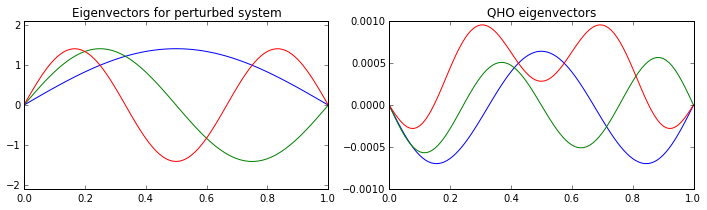

In [10]:
from scipy.special import hermite
from scipy.misc import factorial
from math import pi
root_pi = np.sqrt(pi)
def N(n, alpha):
    return np.sqrt(alpha / (root_pi * (2.0**n) * factorial(n)))
def phi(x,n,alpha):
    return N(n,alpha) * hermite(n)(alpha * x) * np.exp(-0.5 * alpha**2 * x**2)

x2 = np.linspace(-width/2,width/2,num_x_points)
#pl.plot(x,phi(x2,1,np.sqrt(np.sqrt(omega))))

# Define a figure to take two plots
fig3 = pl.figure(figsize=[12,3])
# Add subplots: number in y, x, index number
axb = fig3.add_subplot(121,autoscale_on=False,xlim=(0,1),ylim=(-2.1,2.1))
axb.set_title("Eigenvectors for perturbed system")
axb2 = fig3.add_subplot(122,autoscale_on=False,xlim=(0,1),ylim=(-0.001,0.001))
axb2.set_title("QHO eigenvectors")
#axb2.set_title("Difference to QHO eigenvectors")
for m in range(3): # Plot the first four states
    psi = np.zeros(num_x_points)
    for i in range(num_basis):
        psi = psi+eigvec[i,m]*basis_array[i]
    if 2*(m/2)!=m:  # This is just to ensure that psi and the basis function have the same phase
        psi = -psi
    axb.plot(x,psi)
    psi = psi - basis_array[m]
    #psi = psi - phi(x2,m,np.sqrt(omega))
    axb2.plot(x,psi)

As we would expect, the eigenvectors are almost unchanged.

### Large perturbation - approximate QHO

Now we will go beyond a small perturbation, by making the QHO potential much stronger.  We have to be a little careful how we do this: we'll see the effects of making the potential *too* strong lower down.

  45.776   -0.000   47.494    0.000    8.795    0.000    3.078   -0.000    1.425   -0.000
  -0.000  108.074    0.000   56.290   -0.000   11.874    0.000    4.503   -0.000    2.199
  47.494   -0.000  141.544    0.000   59.368    0.000   13.298   -0.000    5.277    0.000
  -0.000   56.290   -0.000  179.166    0.000   60.793   -0.000   14.072   -0.000    5.744
   8.795   -0.000   59.368   -0.000  225.004   -0.000   61.567    0.000   14.539   -0.000
   0.000   11.874    0.000   60.793   -0.000  280.060   -0.000   62.033    0.000   14.842
   3.078   -0.000   13.298   -0.000   61.567    0.000  344.679   -0.000   62.336   -0.000
  -0.000    4.503   -0.000   14.072    0.000   62.033   -0.000  419.004   -0.000   62.544
   1.425   -0.000    5.277   -0.000   14.539   -0.000   62.336   -0.000  503.104    0.000
   0.000    2.199    0.000    5.744   -0.000   14.842   -0.000   62.544   -0.000  597.013
Perturbation matrix elements:
  40.841   -0.000   47.494   -0.000    8.795    0.000    3.078   -0.00

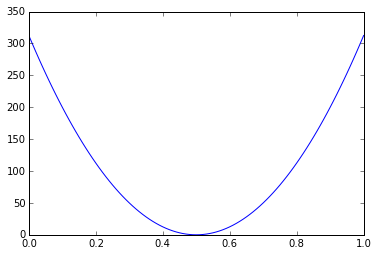

In [19]:
# Make omega larger, so that the QHO energy dominates the square well
omegaL = 50.0
omegaL2 = omegaL*omegaL
VbumpQHO2 = np.linspace(0.0,width,num_x_points)
pot_bump = square_well_potential2(x,VbumpQHO2,omegaL2)

# Declare space for the matrix elements
Hmat3 = np.eye(num_basis)

# Loop over basis functions phi_n (the bra in the matrix element)
for n in range(num_basis):
    # Loop over basis functions phi_m (the ket in the matrix element)
    for m in range(num_basis):
        # Act with H on phi_m and store in H_phi_m
        H_phi_m = -0.5*d2basis_array[m] 
        add_pot_on_basis(H_phi_m,VbumpQHO2,basis_array[m])
        # Create matrix element by integrating
        Hmat3[m,n] = integrate_functions(basis_array[n],H_phi_m,num_x_points,dx)
        # The comma at the end prints without a new line; the %8.3f formats the number
        print "%8.3f" % Hmat3[m,n],
    # This print puts in a new line when we have finished looping over m
    print
    
print "Perturbation matrix elements:"
# Loop over basis functions phi_n (the bra in the matrix element)
for n in range(num_basis):
    # Loop over basis functions phi_m (the ket in the matrix element)
    for m in range(num_basis):
        # Act with H on phi_m and store in H_phi_m
        H_phi_m = np.zeros(num_x_points)
        add_pot_on_basis(H_phi_m,VbumpQHO2,basis_array[m])
        # Create matrix element by integrating
        H_mn = integrate_functions(basis_array[n],H_phi_m,num_x_points,dx)
        # The comma at the end prints without a new line; the %8.3f formats the number
        print "%8.3f" % H_mn,
    # This print puts in a new line when we have finished looping over m
    print
    
# Solve using linalg module of numpy (which we've imported as la above)
eigval, eigvec = la.eigh(Hmat3)
# This call above does the entire solution for the eigenvalues and eigenvectors !
# Print results roughly, though apply precision of 4 to the printing
print
print "Eigenvalues and eigenvector coefficients printed roughly"
np.set_printoptions(precision=4)
print eigval
print eigvec[0]
print eigvec[1]
print eigvec[2]
print

print " QHO Square  Perfect QHO  Difference  Perfect Square Difference"
for i in range(num_basis):
    n = i+1
    print "   %8.3f     %8.3f    %8.3f        %8.3f   %8.3f" % (eigval[i],omegaL*(i+0.5),eigval[i] - omegaL*(i+0.5),n*n*np.pi*np.pi/2.0,eigval[i] - n*n*np.pi*np.pi/2.0)

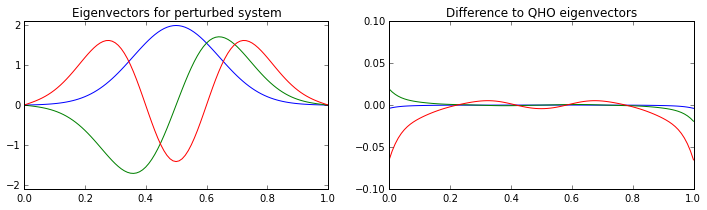

In [12]:
# Define a figure to take two plots
fig4 = pl.figure(figsize=[12,3])
# Add subplots: number in y, x, index number
axc = fig4.add_subplot(121,autoscale_on=False,xlim=(0,1),ylim=(-2.1,2.1))
axc.set_title("Eigenvectors for perturbed system")
axc2 = fig4.add_subplot(122,autoscale_on=False,xlim=(0,1),ylim=(-0.1,0.1))
#axc2.set_title("QHO eigenvectors")
axc2.set_title("Difference to QHO eigenvectors")
for m in range(3): # Plot the first four states
    psi = np.zeros(num_x_points)
    for i in range(num_basis):
        psi = psi+eigvec[i,m]*basis_array[i]
    #if 2*(m/2)!=m:  # This is just to ensure that psi and the basis function have the same phase
    #    psi = -psi
    axc.plot(x,psi)
    psi = psi - phi(x2,m,np.sqrt(omegaL))
    axc2.plot(x,psi)

Now we can see two things:

* For the lower eigenvalues, the energy is almost a perfect match to the QHO, and the eigenvectors are also an excellent match (except at the edges, where the hard walls of the square well will have an effect)
* For the higher eigenvalues, once the energy is within 10-20% of the energy at the top of the QHO potential, the eigenvalues diverge strongly 

This second result comes about when the perturbation (the QHO well) becomes comparable to the square well energy.  If we went higher in energy, we'd gradually recover the square well eigenvalues.

## Basis set size

We'll now see the problem with using a finite basis set (we defined `num_basis`, the number of basis functions to include, as 10 above, to make matrices a sensible size).  If we make the QHO potential *huge* compared to the square well eigenvalues, we'll find that the resulting eigenfunctions are very compressed, and that our ten square well eigenstates are not enough to properly represent them.  

The calculation takes the usual form: define a potential; form a Hamiltonian matrix (we won't print the potential matrix this time); diagonalise; analyse the results.

4089.027    0.000 4749.429   -0.000  879.522    0.000  307.831   -0.000  142.479    0.000
  -0.000 8853.261   -0.000 5628.951   -0.000 1187.353   -0.000  450.310   -0.000  219.873
4749.429   -0.000 9757.457    0.000 5936.782    0.000 1329.832    0.000  527.703    0.000
  -0.000 5628.951   -0.000 10099.831   -0.000 6079.261   -0.000 1407.225   -0.000  574.367
 879.522   -0.000 5936.782    0.000 10286.723   -0.000 6156.655   -0.000 1453.889   -0.000
   0.000 1187.353    0.000 6079.261   -0.000 10418.400   -0.000 6203.318   -0.000 1484.172
 307.831   -0.000 1329.832   -0.000 6156.655   -0.000 10529.215   -0.000 6233.601   -0.000
  -0.000  450.310    0.000 1407.225   -0.000 6203.318   -0.000 10633.521   -0.000 6254.361
 142.479   -0.000  527.703   -0.000 1453.889   -0.000 6233.601   -0.000 10738.172   -0.000
   0.000  219.873    0.000  574.367   -0.000 1484.172   -0.000 6254.361   -0.000 10846.779
 QHO Square  Perfect QHO  Difference
    341.200      250.000      91.200
   1091.149      75

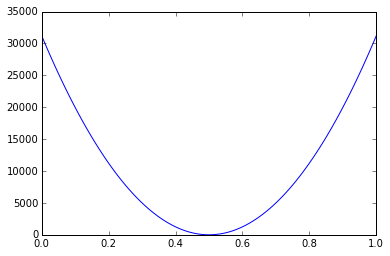

In [23]:
# Make omega larger, so that the QHO energy dominates the square well
omegaH = 500.0
omegaH2 = omegaH*omegaH
VbumpQHO3 = np.linspace(0.0,width,num_x_points)
pot_bump = square_well_potential2(x,VbumpQHO3,omegaH2)

# Declare space for the matrix elements
Hmat4 = np.eye(num_basis)

# Loop over basis functions phi_n (the bra in the matrix element)
for n in range(num_basis):
    # Loop over basis functions phi_m (the ket in the matrix element)
    for m in range(num_basis):
        # Act with H on phi_m and store in H_phi_m
        H_phi_m = -0.5*d2basis_array[m] 
        add_pot_on_basis(H_phi_m,VbumpQHO3,basis_array[m])
        # Create matrix element by integrating
        Hmat4[m,n] = integrate_functions(basis_array[n],H_phi_m,num_x_points,dx)
        # The comma at the end prints without a new line; the %8.3f formats the number
        print "%8.3f" % Hmat4[m,n],
    # This print puts in a new line when we have finished looping over m
    print
    
# Solve using linalg module of numpy (which we've imported as la above)
eigval, eigvec = la.eigh(Hmat4)
print " QHO Square  Perfect QHO  Difference"
for i in range(num_basis):
    n = i+1
    print "   %8.3f     %8.3f    %8.3f" % (eigval[i],omegaH*(i+0.5),eigval[i] - omegaH*(i+0.5))

Here's the first clue that we have a problem: the eigenvalues from the matrix using the limited square well basis set are too high.  They are in significant error.  Let's plot the resulting eigenfunctions, along with the perfect eigenfunctions, to compare.  (As before, don't worry about the minus sign in the functions - this is just a phase.)

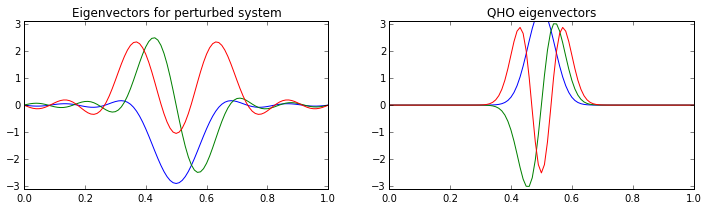

In [32]:
# Define a figure to take two plots
fig5 = pl.figure(figsize=[12,3])
# Add subplots: number in y, x, index number
axd = fig5.add_subplot(121,autoscale_on=False,xlim=(0,1),ylim=(-3.1,3.1))
axd.set_title("Eigenvectors for perturbed system")
axd2 = fig5.add_subplot(122,autoscale_on=False,xlim=(0,1),ylim=(-3.1,3.1))
#axc2.set_title("QHO eigenvectors")
axd2.set_title("QHO eigenvectors")
for m in range(3): # Plot the first four states
    psi = np.zeros(num_x_points)
    for i in range(num_basis):
        psi = psi+eigvec[i,m]*basis_array[i]
    if 2*(m/2)!=m:  # This is just to ensure that psi and the basis function have the same phase
        psi = -psi
    axd.plot(x,psi)
    #psi = psi - phi(x2,m,np.sqrt(omegaH))
    #axd2.plot(x,psi)
    axd2.plot(x,phi(x2,m,np.sqrt(omegaH)))

Here we see the problem: the sum over the basis functions (left graph) contains ringing.  We would need to include many more basis functions to correctly represent these rapidly varying functions (if you remember Fourier analysis, you might like to think about what this means in terms of Fourier analysis).

Feel free to play with `num_basis` and see how the agreement improves with basis size.